# Lab time series analysis: COVID-19 data


In this lab assignment, we will make use of the COVID-19 dataset maintained by [Our World in Data](https://ourworldindata.org/coronavirus), published on Github at <https://github.com/owid/covid-19-data/tree/master/public/data>.

In [92]:
# Package imports for data science and time series analysis in particular
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd;
import scipy.stats as stats;
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

First, we import the dataset, parse the `date` column as the Python `DateTime` type and set this as the index:

In [93]:
covid19 = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', parse_dates=['date']).set_index(['date'])
covid19.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,5.0,5.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-25,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-26,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-27,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-28,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Maak een nieuwe dataframe die enkel de nieuwe gevallen in België bevat. Visualiseer de dataframe met een plot en geef het figsize 20 op 10.

<AxesSubplot:xlabel='date'>

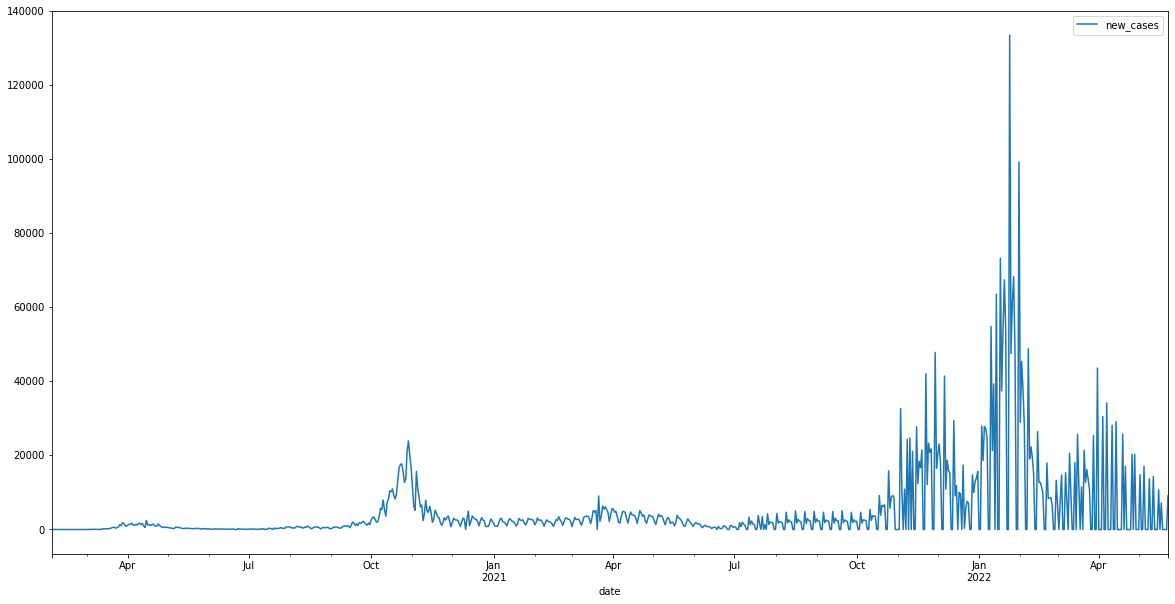

In [94]:
covid19_be = covid19[covid19['location'] == 'Belgium'][['new_cases']]
covid19_be.plot(y=['new_cases'],figsize=(20,10))

## Moving average

Maak twee nieuwe kolommen met een kortlopende moving average van zeven dagen en een langlopende moving average van 30 dagen. Plot zowel de moving averages als de nieuwe gevallen.

In [95]:
covid19_be['SMA7'] = covid19_be['new_cases'].rolling(7).mean()
covid19_be['SMA30'] = covid19_be['new_cases'].rolling(30).mean()

<AxesSubplot:xlabel='date'>

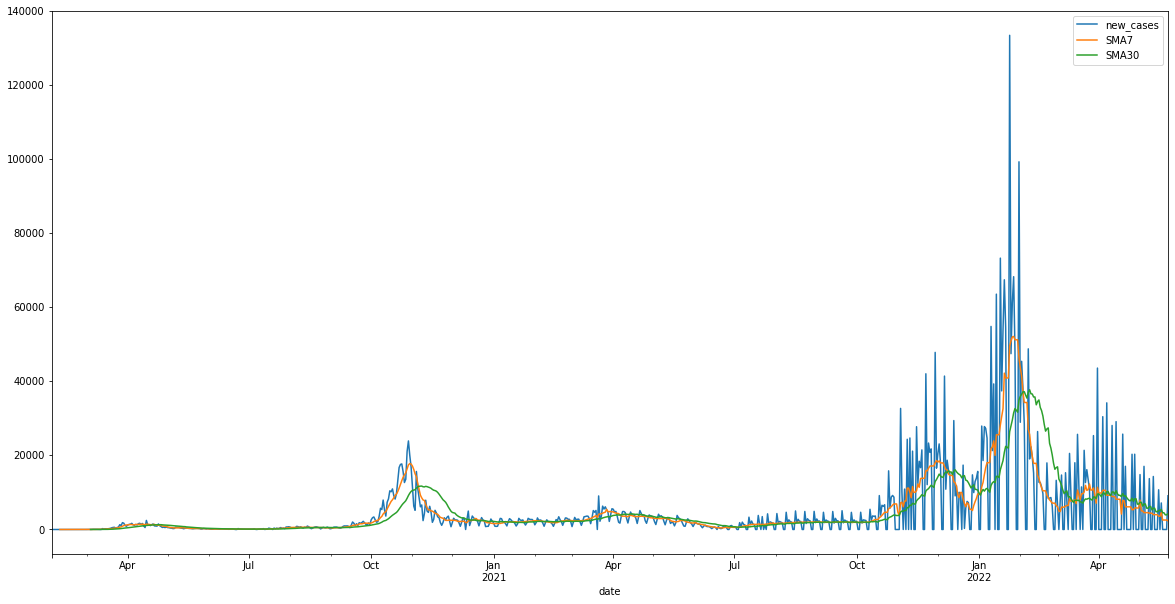

In [96]:
covid19_be.plot(y=['new_cases','SMA7','SMA30'],figsize=(20,10))

## Holt-Winters model for new cases early 2021

The period from about December 2020 up to the end of February 2021 seems quite regular. Create a new `DataFrame` and select only the observations during that period (1 December 2020 to 28 February 2021). Plot the `DataFrame` (it will still contain the moving averages from the previous step).

<AxesSubplot:xlabel='date'>

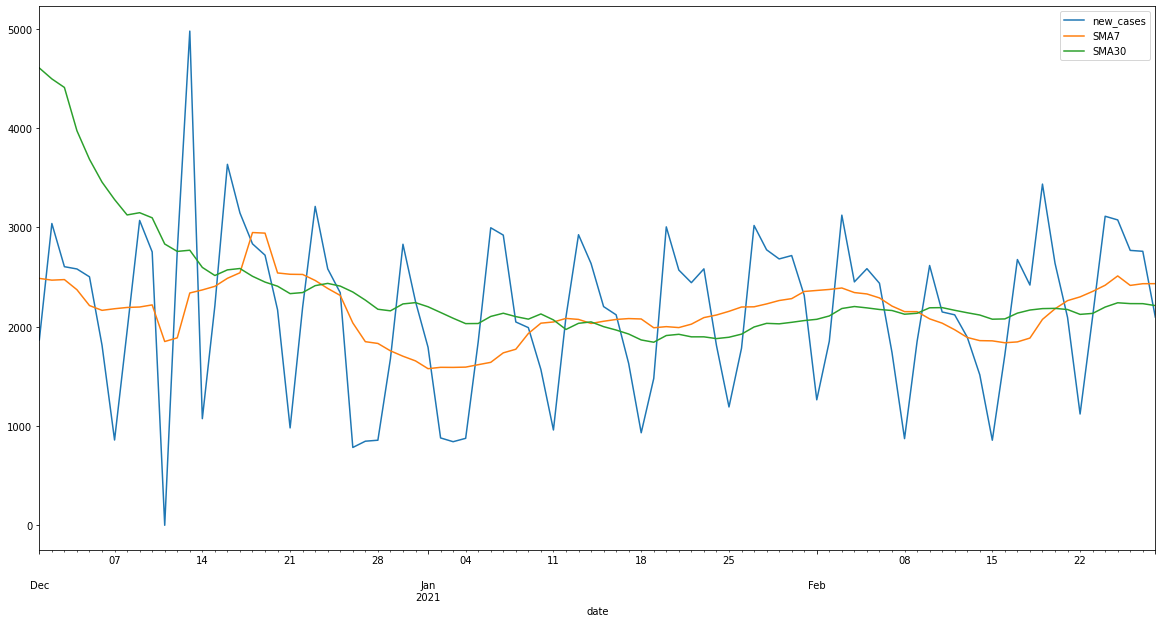

In [97]:
#vb = datetime.strptime('datum','formaat')

start = datetime.strptime('2020-12-01','%Y-%m-%d')
einde = datetime.strptime('2021-02-28','%Y-%m-%d')

# Periode afbakenen.
new_cases_eerste_twee_maanden = covid19_be[start:einde]

# Periode plotten.
new_cases_eerste_twee_maanden.plot(figsize=(20,10))


**Exponential smoothing** is a method that addresses both points of criticism. It bases its
predictions on a weighted average of past observations, with more weight on the more recent
observations, and it requires very little data storage. Moreover, it is not difficult for most business people to understand, at least conceptually. Therefore, this method is widely used in the
business world, especially when frequent and automatic forecasts of many items are required.
There are many variations of exponential smoothing.
**Single exponential smoothing** is appropriate for a series with no pronounced trend or seasonality. **Holt's method** is appropriate for a series with trend but no seasonality.
**Winters' method** is appropriate for a series with seasonality (and possibly trend).

Build a Holt-Winters model for the observed new cases during that period.

Use the additive type for both trend and seasonal smoothing. Set the value for `seasonal_periods` to the appropriate value! Plot the observed and fitted values.

In [98]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Model trainen.
# We slaan het Holt-Winters model op onder een nieuwe var.
# Eerst geven we de periode mee van daarnet (Januari-Februari) als traindata.
# De trend is additive --> 'add'
# De 
covid_hw = ExponentialSmoothing(new_cases_eerste_twee_maanden.new_cases,
trend='add', seasonal='add', seasonal_periods=7, freq='D').fit()

<AxesSubplot:xlabel='date'>

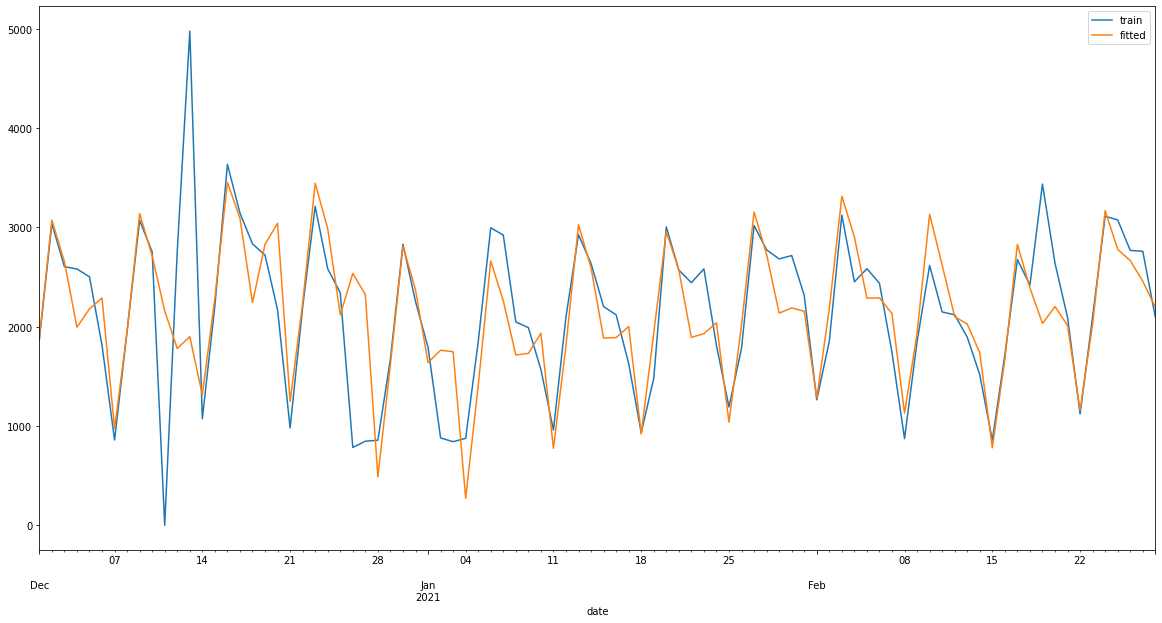

In [99]:
# Fitted values ophalen.
new_cases_eerste_twee_maanden.plot(y='new_cases', legend=True, label='train',figsize=(20,10))
covid_hw.fittedvalues.plot(legend=True, label='fitted')

Now, make a forecast for 21 days and plot observed and forecasted values. What do you notice when you compare observed and forecasted values as time progresses?

In [100]:
# De range van datums bijhouden in twee variabelen.
maart1 = datetime.strptime('2021-03-01','%Y-%m-%d')
maart21 = datetime.strptime('2021-03-21','%Y-%m-%d')

# Gebruik de effectieve waarde uit de oorspronkelijke dataframe.
# Haal de nieuwe gevallen op (dubbele vierkante haakjes!)
# Sla dit op onder een nieuwe variabele.
# Dit is de testdata.
covid_maart = covid19_be[maart1:maart21]['new_cases']

In [101]:
# Holt-Winters model aanspreken en hierop een voorspelling doen van 21 dagen.
# Dit is een voorspelling die we hebben gemaakt.
covid_fc = covid_hw.forecast(21)

Het verschil tussen 'covid_fc' en 'covid_maart' is dat de forecast een voorspelling is.

Text(0.5, 1.0, 'baller')

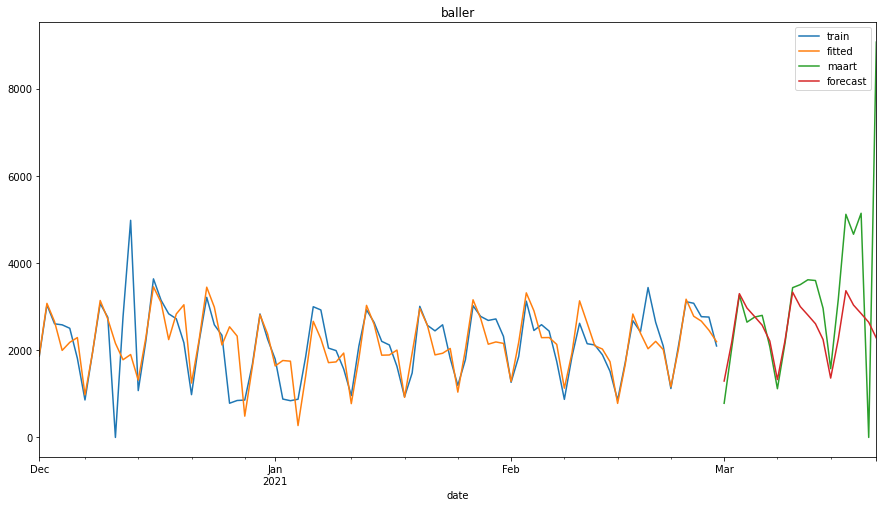

In [102]:
# Historische data
new_cases_eerste_twee_maanden.plot(y='new_cases',legend=True,label='train',figsize=(15,8))

# Hoe goed het model aansluit bij de oorspronkelijke data.
covid_hw.fittedvalues.plot(legend=True, label='fitted')

# De werkelijke waarden van Maart.
covid_maart.plot(legend=True, label='maart')

# De forecast die we hebben gemaakt.
covid_fc.plot(legend=True, label='forecast')

plt.title('baller')

## Evaluating model quality


- Calculate the Mean Squared Error for a forecast period of 7 days, and compare its square root with the standard deviation of observed new cases over the test period and forecasted period combined.
- Do the same for a forecast period of 14 and 21 days.
- For which period is the quality of the forecast ok?

The expected results are shown in the table below:

|     Forecast period      |         MSE |     √MSE |    stdev |
| :----------------------: | ----------: | -------: | -------: |
| 2021-03-01 to 2021-03-07 |   64617.220 |  254.199 |  811.826 |
| 2021-03-01 to 2021-03-14 |  208014.899 |  456.087 |  837.483 |
| 2021-03-01 to 2021-03-21 | 3228834.183 | 1796.896 | 1154.486 |

In [103]:
from sklearn.metrics import mean_absolute_error, mean_squared_error



# Voor de twee methoden moet je telkens de effectieve waarden (covid_maart) gaan meegeven met de forecast.
MAE = mean_absolute_error(covid_maart, covid_fc)
MSE = mean_squared_error(covid_maart, covid_fc)
MSE_squared = np.sqrt(MSE)

# Voor de standaardafwijking kijken we naar het bereik tussen start tot en met 21 maart. 
std = covid19_be[start:maart21]['new_cases'].std()

## ICU patients

Create a new `DataFrame` with only the total number of ICU (intensive care units) patients in the Belgian hospitals. Make sure that all NaN's are removed, since time series analysis functions can't cope with missing values. Plot this time series. 

<AxesSubplot:xlabel='date'>

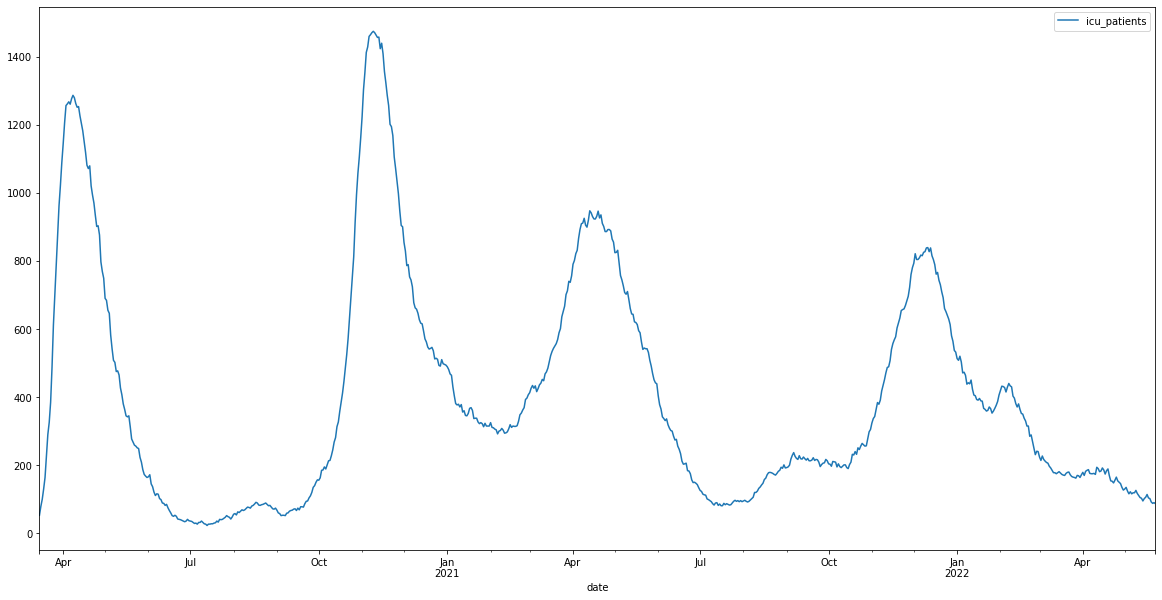

In [107]:
# dropna gaat alle NaN-waarden uit de databank halen.
# als je de NaN-waarden wilt veranderen door een andere waarde moet je gebruik maken van .fillna(..)
icu = covid19[covid19.iso_code=='BEL'][['icu_patients']].dropna()
icu.plot(figsize=(20,10))

We moeten geen parameters opgeven voor alpha en beta. Bouw een Holt-Winters model (double) op.

C:\Users\dylan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='date'>

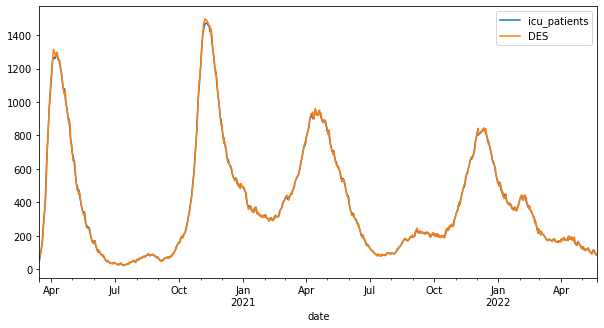

In [127]:
from statsmodels.tsa.api import Holt

# Het Holt-model fitten.
icu_des = Holt(icu['icu_patients']).fit()

# De gefitte waarden opslaan onder een nieuw variabele.
icu['DES'] = icu_des.fittedvalues

# Plotten.
icu.plot(figsize=(10,5))

<AxesSubplot:xlabel='date'>

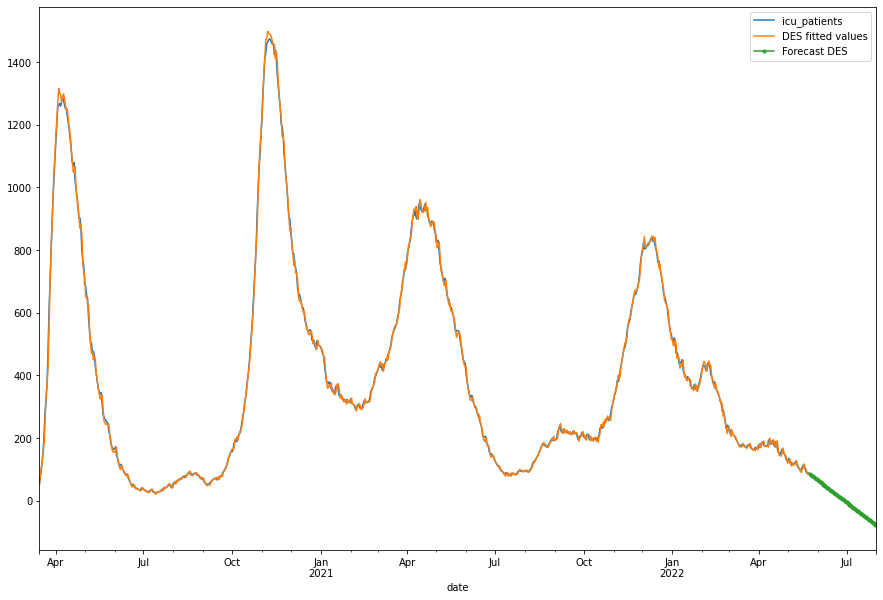

In [151]:
# Alle observaties
icu['icu_patients'].plot(legend=True, figsize=(15,10))

# De gefitte waarden.
icu['DES'].plot(legend=True, label='DES fitted values')

# De forecast.
icu_des_fcast = icu_des.forecast(70)
icu_des_fcast.plot(marker='.',legend=True,label='Forecast DES')

Since we didn't set any initial parameters like $\alpha$ and $\beta$, the model calculated them using some rule of thumb. List these parameters from the model:

In [130]:
icu_des.params_formatted

,name,param,optimized
smoothing_level,alpha,0.958466,True
smoothing_trend,beta,0.389901,True
initial_level,l.0,21.387240,True
initial_trend,b.0,31.202700,True


Wat waren de twee waarden op de trend van het allerlaatste tijdstip? Geef de waarden die de trend tussen de vorige twee waarden zo goed mogelijk benaderd.

In [138]:
laatste = len(icu_des.level)-1

print(f'Laatste level: {icu_des.level[laatste]:.3f}')
print(f'Laatste trend: {icu_des.trend[laatste]:.3f}')

Laatste level: 87.023
Laatste trend: -2.370


Let's try to set the parameters ourselves. Recreate the Holt-model with $\alpha = \beta = 0.1$. Calculate a forecast like before and plot.

C:\Users\dylan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='date'>

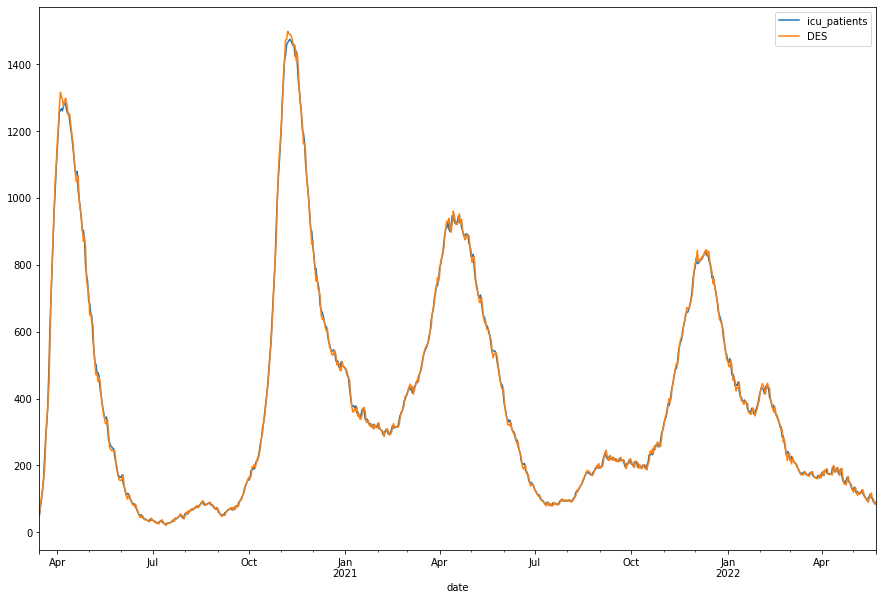

In [146]:
from statsmodels.tsa.api import Holt

icu_des = Holt(icu['icu_patients']).fit()
icu['DES'] = icu_des.fittedvalues
icu.plot(figsize=(15,10))

<AxesSubplot:xlabel='date'>

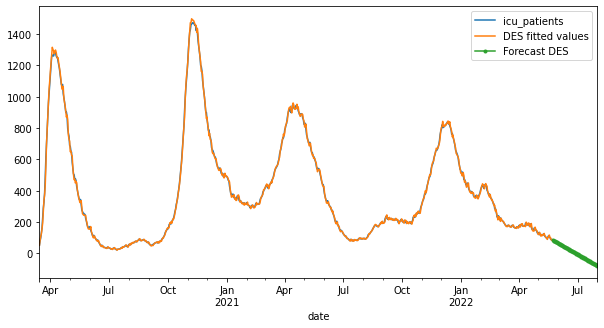

In [147]:
icu_des_fcast = icu_des.forecast(70)

icu['icu_patients'].plot(legend=True)
icu['DES'].plot(legend=True, label='DES fitted values', figsize=[10,5])
icu_des_fcast.plot(marker='.', legend=True, label='Forecast DES')

In [148]:
icu_des.params_formatted

,name,param,optimized
smoothing_level,alpha,0.958466,True
smoothing_trend,beta,0.389901,True
initial_level,l.0,21.387240,True
initial_trend,b.0,31.202700,True


In [149]:
laatste = len(icu_des.level)-1

print(f'Laatste level: {icu_des.level[laatste]:.3f}')
print(f'Laatste trend: {icu_des.trend[laatste]:.3f}')

Laatste level: 87.023
Laatste trend: -2.370
